1. Run the 1D convnet in DLWP Listings 6.45 and 6.46. Compare the result with the feedforward approach of Part 1 of DLWP. Experiment with different hyperparameters.

2. The word embeddings model of Listing 6.16 underperforms the pretrained embeddings model. But does it perform better when there is more data? Investigate if accuracy improves when the training set is increased. 

3. Try an improve the results of advanced RNN models in DLWP Section 6.3 by:
    - adjusting the number of units in each recurrent layer
    - trying different learning rates
    - substituting LSTM layers for GRU layers
    - trying bigger densely connected regressors on top of the recurrent base, or even a stack of dense layers

Remember to run the best performing models on the test set

# Task1

## Run the 1D convnet in DLWP Listings 6.45 and 6.46

In [ ]:
# import libraries
from google.colab import drive
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import preprocessing
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.models import Sequential
from tensorflow.keras import models
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.utils import np_utils

import warnings
warnings.filterwarnings("ignore")

import nltk
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
#define variables
max_features = 10000
max_len = 500
max_dim = 128
max_batch_size = 128
max_epochs = 10
learn_rate = 1e-4

In [ ]:
# General functions
def remove_stop_words(wordsBag,stopwords):
    for word in list(wordsBag): # iterating on a copy since removing will mess things up
        if word in stopwords:
            wordsBag.remove(word)


def load_data():
  #read csv file
  from google.colab import drive
  drive.mount('/content/gdrive')
  phones = '/content/gdrive/My Drive/Colab Datasets/phones/items.csv'
  phones_reviews = '/content/gdrive/My Drive/Colab Datasets/phones/reviews.csv'
  cols = ['title', 'rating', 'body']
  df = pd.read_csv(phones_reviews, usecols=cols)
  #replace values
  df.fillna('',inplace=True)
  df['review'] = df['title'] + ' ' + df['body']
  df.loc[df['rating'] == 3,'rating'] = 'neutral'
  df.loc[(df['rating'] == 1) | (df['rating'] == 2),'rating'] = 'bad'
  df.loc[(df['rating'] == 4) | (df['rating'] == 5),'rating'] = 'good'
  df.drop(labels=['title', 'body'], axis=1, inplace=True)
  #create bag of words out of reviews
  bagOfWords_list = []
  for review in df['review']:
    bagOfWords_list.append([w.lower() for w in nltk.word_tokenize(review) if len(w) > 2])
  #clean and remove stop words
  stopwords = nltk.corpus.stopwords.words('english')
  for words in bagOfWords_list:
    remove_stop_words(words,stopwords)
  #tokenize reviews
  tizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_features)
  tizer.fit_on_texts(bagOfWords_list)
  #create sequences from reviews' bag of words
  sequences = tizer.texts_to_sequences(bagOfWords_list)
  #encode labels
  le = preprocessing.LabelEncoder()
  le.fit(df['rating'])
  labels = le.transform(df['rating'])
  #split dataset
  X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, stratify=labels, shuffle=True)
  return X_train, y_train, X_test, y_test, df

def print_results(history, label):
    measure = history.history[label]
    val_measure = history.history[f'val_{label}']
    print(f'max acc: {max(measure)}')
    print(f'max val. acc: {max(val_measure)}')

def plot_results(results, label):
    import matplotlib.pyplot as plt

    measure = results.history[label]
    val_measure = results.history[f'val_{label}']

    epochs = range(1, len(measure) + 1)

    blue_dots = 'bo'
    solid_blue_line = 'b'

    plt.plot(epochs, measure, blue_dots, label = f'Training {label}')
    plt.plot(epochs, val_measure, solid_blue_line, label = f'Validation {label}')
    plt.title(f'Training and validation {label}')
    plt.xlabel('Epochs')
    plt.ylabel(label)
    plt.legend()

    plt.show()

In [ ]:
#convolutional model functions

def process_conv_data(train_data, test_data, max_ln = max_len):
    print('Pad sequences (samples x time)')
    x_train = sequence.pad_sequences(train_data, maxlen=max_ln,padding='post')
    x_test = sequence.pad_sequences(test_data, maxlen=max_ln,padding='post')
    print('x_train shape:', x_train.shape)
    print('x_test shape:', x_test.shape)
    return x_train, x_test

def build_train_conv_model(train_data, test_data,features_len = max_features, dim = max_dim,
                           epochs_no = max_epochs, batch_size = max_batch_size, 
                           input_len=max_len,steps_config=[[32,7,1],[5,1],[32,7,1]], flatten_last_step = False):
    model = Sequential()
    model.add(layers.Embedding(features_len, dim, input_length=input_len))
    
    layer1 = layers.Conv1D(filters=steps_config[0][0], kernel_size=steps_config[0][1], 
                           strides=steps_config[0][2], activation='relu')
    
    pooling1 =layers.MaxPooling1D(pool_size=steps_config[1][0],strides=steps_config[1][1])

    layer2 = layers.Conv1D(filters=steps_config[2][0], kernel_size=steps_config[2][1], 
                           strides=steps_config[2][2], activation='relu')

    model.add(layer1)
    model.add(pooling1)
    model.add(layer2)
    
    if(flatten_last_step):
      model.add(layers.Flatten())
    else:
      model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(3, activation = 'softmax'))
    model.summary()
    model.compile(optimizer=Adam(lr=learn_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

    dummy_y = np_utils.to_categorical(train_labels)
    history = model.fit(train_data, dummy_y,
    epochs=epochs_no,
    batch_size=batch_size,
    validation_split=0.2,
    verbose=0) # class_weight={0: 2.0406411333893626, 1: 0.7298394022672622, 2: 7.153409090909091}
    return model, history



In [ ]:
#feed forward functions
def vectorize_sequences(data, dimension = max_features):
    results = np.zeros( (len(data), dimension) )
    for i, sequence in enumerate(data):
        results[i, sequence] = 1.
    return results


def preprocess_ff_data(train_data, test_data, train_labels, test_labels):
    x_train = vectorize_sequences(train_data)
    x_test = vectorize_sequences(test_data)

    y_train = np.asarray(train_labels).astype('float32')
    y_test = np.asarray(test_labels).astype('float32')
    return x_train, y_train, x_test, y_test

def build_train_ff_model(train_data, test_data,features_len = max_features, 
                           epochs_no = max_epochs, batch_size = max_batch_size, 
                           input_len=max_len):


    model = models.Sequential()
    model.add(layers.Dense(16, activation = 'relu', input_shape = (max_features,)))
    model.add(layers.Dense(16, activation = 'relu'))
    model.add(layers.Dense(3, activation = 'softmax'))

    model.compile(optimizer=Adam(lr=learn_rate),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    # train
    dummy_y = np_utils.to_categorical(train_labels)
    history = model.fit(train_data, 
                        dummy_y,
                        epochs = epochs_no,
                        batch_size = max_batch_size,
                        validation_split= 0.25,
                        verbose = 0) # class_weight={0: 2.0406411333893626, 1: 0.7298394022672622, 2: 7.153409090909091}
    return model, history

In [ ]:
train_data, train_labels, test_data, test_labels, df = load_data()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
conv_train_data, conv_test_data = process_conv_data(train_data, test_data)

Pad sequences (samples x time)
x_train shape: (54388, 500)
x_test shape: (13598, 500)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 128)          1280000   
                                                                 
 conv1d (Conv1D)             (None, 494, 32)           28704     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 490, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 484, 32)           7200      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 3)                 9

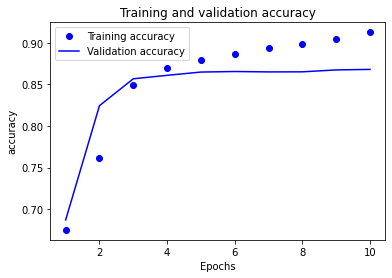

In [ ]:
#convolutional model
conv_model, conv_results = build_train_conv_model(conv_train_data, conv_test_data)
print_results(conv_results, 'accuracy')
plot_results(conv_results, 'accuracy')

max acc: 0.9003456830978394
max val. acc: 0.873354434967041


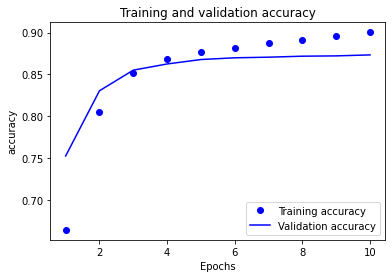

In [ ]:
#feedforward model
ff_train_data, ff_train_labels, ff_test_data, ff_test_labels = \
    preprocess_ff_data(train_data, test_data,train_labels, test_labels)

ff_model, ff_results = build_train_ff_model(ff_train_data, ff_test_data,max_features,
                           max_epochs, max_dim, max_len)
print_results(ff_results,'accuracy')
plot_results(ff_results, 'accuracy')

## Compare the result with the feedforward approach of Part 1 of DLWP

After running both models (feed forward / convolutional) with the same hyperparameters values in terms of epochs, batch size words length etc...I noticed that the feed forward model(FF) performed slightly better than the convolutional model (CONV) scoring a validation accuracy of ~87% comparing with ~86% for the CONV model.

In [ ]:
print('CONV. Model')
print('=============')
print_results(conv_results, 'accuracy')
print('FF Model')
print('=============')
print_results(ff_results, 'accuracy')

CONV. Model
max acc: 0.9128705859184265
max val. acc: 0.8681743144989014
FF Model
max acc: 0.9003456830978394
max val. acc: 0.873354434967041


## Experiment with different hyperparameters

Pad sequences (samples x time)
x_train shape: (54388, 500)
x_test shape: (13598, 500)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 256)          1280000   
                                                                 
 conv1d_2 (Conv1D)           (None, 166, 128)          163968    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 164, 128)         0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 54, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                  

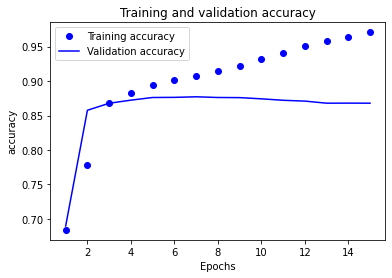

In [ ]:
#Trying different parameters for CONV model
conv2_train_data, conv2_test_data = process_conv_data(train_data, test_data)
conv2_model, conv2_results = build_train_conv_model(conv2_train_data, conv2_test_data,
                                                   features_len = 5000,
                                                   dim = 256,
                                                   epochs_no = 15, batch_size = 256, 
                                                   input_len=500,
                                                   steps_config=[[128,5,3],[3,1],[64,5,3]],
                                                   flatten_last_step = False)
print_results(conv2_results, 'accuracy')
plot_results(conv2_results, 'accuracy')

Pad sequences (samples x time)
x_train shape: (54388, 300)
x_test shape: (13598, 300)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 512)          1536000   
                                                                 
 conv1d_4 (Conv1D)           (None, 98, 256)           917760    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 92, 256)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 29, 256)           459008    
                                                                 
 flatten (Flatten)           (None, 7424)              0         
                                                                 
 dense_5 (Dense)             (None

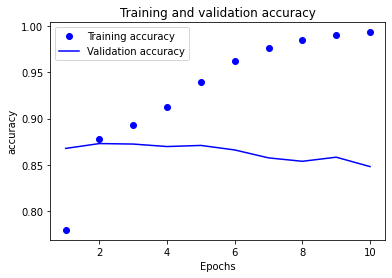

In [ ]:
#Trying different parameters for CONV model
conv3_train_data, conv3_test_data = process_conv_data(train_data, test_data,max_ln=300)
conv3_model, conv3_results = build_train_conv_model(conv3_train_data, conv3_test_data,
                                                   features_len = 3000,
                                                   dim = 512,
                                                   epochs_no = 10, batch_size = 64, 
                                                   input_len=300,
                                                   steps_config=[[256,7,3],[7,1],[256,7,3]],
                                                   flatten_last_step = True)
print_results(conv3_results, 'accuracy')
plot_results(conv3_results, 'accuracy')

Pad sequences (samples x time)
x_train shape: (54388, 100)
x_test shape: (13598, 100)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 64)           64000     
                                                                 
 conv1d_6 (Conv1D)           (None, 98, 8)             1544      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 96, 8)            0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 94, 4)             100       
                                                                 
 global_max_pooling1d_2 (Glo  (None, 4)                0         
 balMaxPooling1D)                                                
                                  

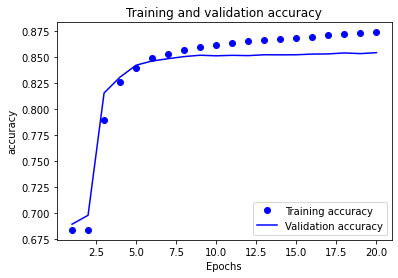

In [ ]:
#Trying different parameters for CONV model
conv4_train_data, conv4_test_data = process_conv_data(train_data, test_data,max_ln=100)
conv4_model, conv4_results = build_train_conv_model(conv4_train_data, conv4_test_data,
                                                   features_len = 1000,
                                                   dim = 64,
                                                   epochs_no = 20, batch_size = 64, 
                                                   input_len=100,
                                                   steps_config=[[8,3,1],[3,1],[4,3,1]],
                                                   flatten_last_step = False)
print_results(conv4_results, 'accuracy')
plot_results(conv4_results, 'accuracy')

# Task 2

## Run code of Listing 6.16

does the model perform better when there is more data? Investigate if accuracy improves when the training set is increased

the keras imdb dataset has 25,000 training samples and 25,000 test samples.
I will concatenate train and test samples (50,000) then try 4 training scenarios as following:

1.  50% validation data => 25,000 for training, 25,000 for validation
2.  30% validation data => 35,000 for training, 15,000 for validation
3.  20% validation data => 40,000 for training, 10,000 for validation
4.  10% validation data => 45,000 for training, 5,000 for validation




In [ ]:
maxlen = 100
training_samples = 200
validation_samples = 10000
max_words = 10000
embedding_dim = 100

In [ ]:
from keras.datasets import imdb
from keras.preprocessing import sequence
print('Loading data...')
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=max_words)
print(len(train_data), 'train sequences')
print(len(test_data), 'test sequences')

train_data = np.append(train_data, test_data)
y_train = np.append(train_labels, test_labels)

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(train_data, maxlen=maxlen,padding='post')
print('x_train shape:', x_train.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (50000, 100)


In [ ]:
def imdb_reviews_classification_model(val_split=0.2):
  model = Sequential()
  model.add(layers.Embedding(max_words, embedding_dim, input_length=maxlen))
  model.add(layers.Flatten())
  model.add(layers.Dense(32, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop',
  loss='binary_crossentropy',
  metrics=['acc'])
  
  history = model.fit(x_train, y_train,
  epochs=10,
  batch_size=32,
  validation_split = val_split,
  verbose=0)
  print_results(history,'acc')
  plot_results(history,'acc')


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 flatten_1 (Flatten)         (None, 10000)             0         
                                                                 
 dense_7 (Dense)             (None, 32)                320032    
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
max acc: 1.0
max val. acc: 0.8366400003433228


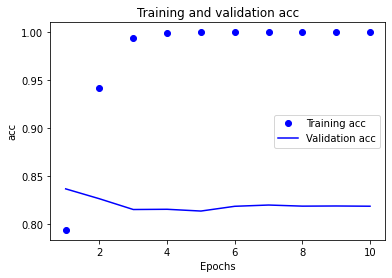

In [ ]:
imdb_reviews_classification_model(0.5)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 flatten_2 (Flatten)         (None, 10000)             0         
                                                                 
 dense_9 (Dense)             (None, 32)                320032    
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
max acc: 1.0
max val. acc: 0.8633333444595337


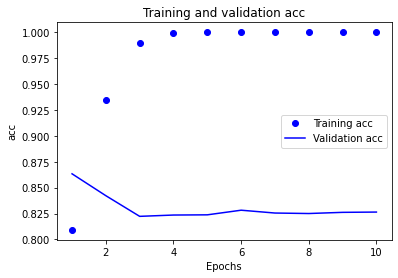

In [ ]:
imdb_reviews_classification_model(0.3)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 flatten_3 (Flatten)         (None, 10000)             0         
                                                                 
 dense_11 (Dense)            (None, 32)                320032    
                                                                 
 dense_12 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
max acc: 1.0
max val. acc: 0.8615000247955322


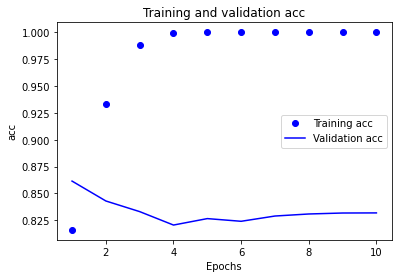

In [ ]:
imdb_reviews_classification_model(0.2)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 flatten_4 (Flatten)         (None, 10000)             0         
                                                                 
 dense_13 (Dense)            (None, 32)                320032    
                                                                 
 dense_14 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
max acc: 1.0
max val. acc: 0.8664000034332275


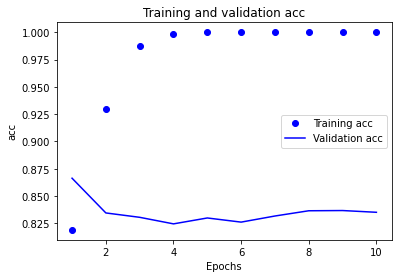

In [ ]:
imdb_reviews_classification_model(0.1)

## Observation

Ignoring the accuracy and the overfitting effect, and focusing only on the validation accuracy,
we can clearly notice that increasing the training sample has improved validation accuracy from 
~83% to ~86%